In [2]:
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfdevice import PDFDevice
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import PDFPageAggregator
from pdfminer.layout import LTTextBoxHorizontal, LAParams
from pdfminer.pdfpage import PDFTextExtractionNotAllowed
from pdf_extractor import extract_pdf_content
import glob
import os
import re
import random
from string import digits
import threading
from time import ctime, sleep
from collections import Counter
import graphviz as gz
from time import time
import time
from compare_str import *
from bert4keras.snippets import longest_common_subsequence

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from string import ascii_letters, digits

import nltk
from nltk.tokenize import word_tokenize as wtoken

# File reading and pre-processing

In [4]:
def pdf_process(article):
    content = re.sub(' +', ' ', extract_pdf_content(
        pdfs[num5]))  
    #content=re.sub('-\n', '', content) 
    content = re.sub('\n\n', 'SSSSSSSSSS', content)  
    content = re.sub('\n \n \n', 'SSSSSSSSSS', content)
    content = re.sub('\n \n', 'SSSSSSSSSS', content)
    content = content.replace("\n", "") 
    content = re.sub('SSSSSSSSSS', '\n\n', content)
    content = re.sub(' +', ' ', content) 
    
    return content

In [5]:
def delete_xexo(samll_paragraph):
    samll_paragraph = str(samll_paragraph)
    samll_paragraph = re.sub(r'\\\\x\w{2}','',samll_paragraph)
    samll_paragraph = re.sub(r'\\x\w{2}','',samll_paragraph)
    samll_paragraph = str(samll_paragraph).replace('\\n\\n', ' ')
    samll_paragraph = re.sub(r'\(cid:\d\)','',samll_paragraph)
    
    return samll_paragraph

# Paragraph localization and segmentation

## Primary heading(Extraction of experimental sections)

In [6]:
def key_match(article):
    article = article.encode('utf-8')

    lists = [['Experimental', 'Result'], ['Material', 'Results'],['Experimental', 'Conclusions'],['EXPERIMENTAL', 'RESULTS'], ['Material', 'Conclusions'],['Result','Experimental']]
    
    for (word1, word2) in lists:
        word1 = word1.encode('utf-8')
        word2 = word2.encode('utf-8')
        
        pattern = re.compile(word1 + b'(.*?)' + word2, re.S)

        result = pattern.findall(article)
        if result != []:  
            result = delete_xexo(result)
            break
        else:
            
            result = 0
    return result

## Secondary heading paragraph markers

In [7]:
def experiment_multpragraph_mark (mult_pragraph):
    mult_pragraph = str(mult_pragraph)  
    pattern = re.compile(r"(2\..\.?.[A-Z].{6,50}\\n\\n)",re.S)
    small_titles = pattern.findall(mult_pragraph)
    if small_titles:
        mult_pragraph1=re.sub(r"(2\..\.?.[A-Z].{6,50}\\n\\n)", r"\1\\n\\n",mult_pragraph)
        mult_pragraph1 = re.sub(r"\\n\\n\\n\\n","SSSSSSSSSSSSSSSSSSSSSSSS",mult_pragraph1)
        mult_pragraph1 = re.sub(r"\\n\\n"," ",mult_pragraph1)
        mult_pragraph1 += 'SSSSSSSSSSSSSSSSSSSSSSSS'   
    else:
        mult_pragraph1 = mult_pragraph
    return mult_pragraph1

## Segmentation

In [8]:
def split_paragraph(mult_pragraph):
    word5 = word6 = b'SSSSSSSSSSSS'
    if 'SSSSSSSSSSSSSSSSSSSSSSSS' in mult_pragraph:
        mult_pragraph = mult_pragraph.replace("SSSSSSSSSSSSSSSSSSSSSSSS","SSSSSSSSSSSS",1)
        pattern3 = re.compile(word5+b'(.*?)'+word6,re.S)
        mult_pragraph = mult_pragraph.encode('utf-8')
        divided_paragraph = pattern3.findall(mult_pragraph)   
    else:
        divided_paragraph = mult_pragraph
    return divided_paragraph


## No heading( Full-text traversal)

In [9]:
def IE_traversal(Key_Paragraph):
    catalyst = find_catalyst_name(Key_Paragraph)
    method = find_method(Key_Paragraph)
    support = find_support(Key_Paragraph)
    precursor = find_precursor(Key_Paragraph)
    loading = find_loading(Key_Paragraph)
    dry_sentence = find_dry_sentence(Key_Paragraph)
    dry_tempurature,dry_time = find_dry_condition(dry_sentence)
 
    calcine_sentence = find_calcine_sentence(Key_Paragraph)
    calcine_tempurature,calcine_time = find_calcine_condition(calcine_sentence)

    reduce_sentence = find_reduce_sentence(Key_Paragraph)
    reduce_tempurature,reduce_time = find_reduce_condition(reduce_sentence)

    merge_list_IE = []
    
    merge_list_IE.append(catalyst)
    merge_list_IE.append(method)
    merge_list_IE.append(support)
    merge_list_IE.append(precursor)
    merge_list_IE.append(loading)
    
    merge_list_IE.append(dry_tempurature)
    merge_list_IE.append(dry_time)
    merge_list_IE.append(calcine_tempurature)
    merge_list_IE.append(calcine_time)
    merge_list_IE.append(reduce_tempurature)
    merge_list_IE.append(reduce_time)
    
    return merge_list_IE

In [10]:
def notnull_IE(merge_list_IE):
    
    con2 = 0
    con1 = 0
    for i in range(len(merge_list_IE)):
        every_lis = merge_list_IE[i]
        if i < 5:
            if len(every_lis)!=0:
                con1 = con1+1
            
        else:
            if len(every_lis[0])!=0:
                con2 = con2+1
        
        con = con1 + con2

    return con


def mostinfo_oneparagraph_num(num_list):
    
    temp=[]
    Inf = 0
    for i in range(1):
        temp.append(num_list.index(max(num_list)))
        num_list[num_list.index(max(num_list))]=Inf
    return temp


def determine_paragraph_2(mostinfo_num):
    k=2500
    before_after_threeparagraph = []
    j = mostinfo_num[0]
    p_before = contents[(j-1)*k:(j-1)*k+k]
    p0 = contents[j*k:j*k+k]
    p_after = contents[(j+1)*k:(j+1)*k+k]
    before_after_threeparagraph = p_before+p0+p_after
    before_after_threeparagraph_join = ''.join(before_after_threeparagraph)
    
    return before_after_threeparagraph_join


def NB_validation(para):
    par = []
    par.append(para)
    test = vectorizer.transform(d for d in par)
    pred = clf2.predict(test)
    print('Naive Bayesian model verification：'+str(pred)+'\n')
    
    return pred   

# Naive Bayesian model

In [11]:
doclist = []
classlist = []
data1 = open('prepare.txt','r').read()
data2 = open('other.txt','r').read()
data_catalyst_pre = re.split(r'\n',data1)
data_other = re.split(r'\n',data2)

In [12]:
datalist = []
classlist = []
for i in range(len(data_catalyst_pre)):
    data1 = data_catalyst_pre[i]
    datalist.append(data1)
    classlist.append(1)
for j in range(len(data_other)):
    data2 = data_other[j]
    datalist.append(data2)
    classlist.append(0)

In [13]:
X = datalist
Y = classlist
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2,random_state = 1)

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase=False,encoding='latin-1')
x_train2 = vectorizer.fit_transform(d for d in x_train)
y_train2 = y_train

x_test2 = vectorizer.transform(s for s in x_test)
y_test2 = y_test

clf2 = MultinomialNB(alpha=0.0001)
clf2.fit(x_train2,y_train2)
y_pred = clf2.predict(x_test2)
train_score = clf2.score(x_train2,y_train2)
test_score = clf2.score(x_test2,y_test2)
print('train score: {0}'.format(train_score))
print('test score:{0}'.format(test_score))

train score: 0.9848484848484849
test score:0.9696969696969697


In [14]:
def sklearn_NB(divided_paragraph):
    if len(divided_paragraph)<10:
        X_pred = vectorizer.transform(d for d in divided_paragraph)
        for i in range(len(divided_paragraph)):
            pred = clf.predict(X_pred[i])
            results='Article'+str(num5+1)+':'+article_title+'predicted result: '+str(pred)+'\n'
            print(results)
            
    else:
        para = list(str(divided_paragraph))
        X_pred = vectorizer.transform(para)
        pred = clf.predict(X_pred)
        
        results='Article'+str(num5+1)+':'+article_title+'predicted result: '+str(pred)+'\n'
        print(results)
    

In [15]:
def catalyst_pre_sklearnNB(divided_paragraph):
    
    if len(divided_paragraph)<10:
    
        X_pred = vectorizer.transform(d for d in divided_paragraph)
        for i in range(len(divided_paragraph)):
            
            pred = clf2.predict(X_pred[i])
            if int(pred)==1:
                global key_paragraph
                key_paragraph = divided_paragraph[i]
                
    else:
        key_paragraph = divided_paragraph
        
    return key_paragraph
   

In [16]:
from sklearn.metrics import classification_report
print(clf2)
print(classification_report(y_test2,y_pred))

MultinomialNB(alpha=0.0001)
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       1.00      0.94      0.97        18

    accuracy                           0.97        33
   macro avg       0.97      0.97      0.97        33
weighted avg       0.97      0.97      0.97        33



In [17]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test2,y_pred,labels=[0,1])
print('confusion matrix: ')
print(cm)

confusion matrix: 
[[15  0]
 [ 1 17]]


Text(38.25, 0.5, 'true')

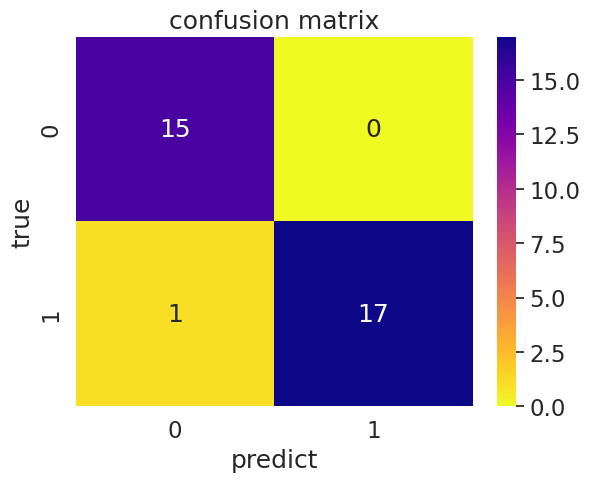

In [18]:
sns.set(font_scale=1.5)
f,ax = plt.subplots()
sns.heatmap(cm,annot=True,cmap='plasma_r')
ax.set_title('confusion matrix')
ax.set_xlabel('predict')
ax.set_ylabel('true')

In [19]:
##### learning_curve

In [20]:
from sklearn.model_selection import validation_curve,learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt 

<module 'matplotlib.pyplot' from '/home/sun/anaconda3/envs/lsy/lib/python3.9/site-packages/matplotlib/pyplot.py'>

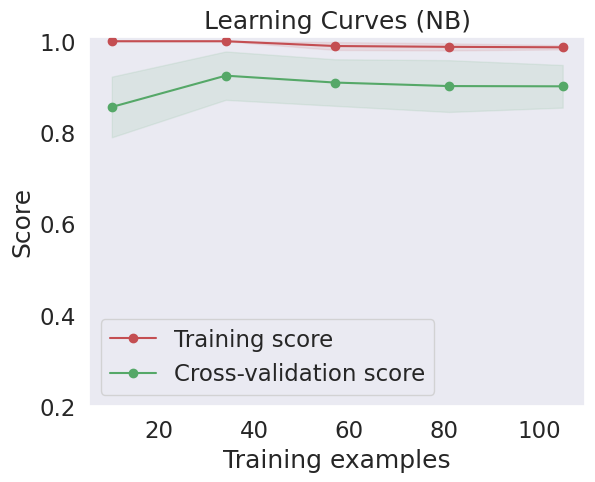

In [21]:
X, y = x_train2, y_train2


title = "Learning Curves (NB)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
#cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = MultinomialNB(alpha=0.0001)
plot_learning_curve(estimator, title, X, y, ylim=(0.2, 1.01), cv=5, n_jobs=4)

# Information Extraction

In [22]:
def find_catalyt_sentence(key_paragraph):
    word = "There is no key sentence"
    catalyst_positioning_words = [
        'catalyst', 'prepar', 'synthesi', 'Catalysts used were'
    ]
    catalyst_sentence = []
    flag = 0
    for k in catalyst_positioning_words:  
        if k in key_paragraph: 
            flag = 1
            key_sentence = "." + key_paragraph
            info_catalyst = re.findall(r"([^.]*?" + str(k) + "[^.]*\.)",
                                       key_sentence)
           
            catalyst_sentence.append(info_catalyst)

    if flag == 1:
        return (catalyst_sentence)
    else:
        return (word)

def find_catalyst_name(catalyst_sentence):
    
    x1 = re.findall(
        '[A-Z]?[a-z]?Pd.{0,20}catalyst|\b[A-Z][a-z][A-Z][a-z][A-Z][a-z]\b|[A-Z]?\w?[A-Z]\w\/[A-Z][a-z]\d?[A-Z]\d',
        str(catalyst_sentence))
   
    x2 = re.findall(
        '[A-Z][a-z]\/-?\S*|[A-Z][a-z]Pd\/-?\S*|Pd[A-Z][a-z]\/-?\S*|Pd[A-Z][a-z][A-Z][a-z]|formula o?f? ?[A-Z]\S*|identied as [A-Z].{10,15}|denoted as [A-Z]\w+',
        str(catalyst_sentence))
    x2 = list(set(x2)) 
    x1 = list(set(x1))
    if len(x1) != 0:
        return x1
    else:
        return x2

def find_method(key_paragraph):
    reg = re.compile(
        r"(prepared|synthesized) (by|using|via)(.*?)(technique|method|using|of|\. |\, )\b"
    )

    reg2 = re.compile(
        r'impregnat\S*|precipitation|deposition|incipient wetness')

    x = reg.findall(str(key_paragraph))
    x = list(set(x))

    x2 = reg2.findall(str(key_paragraph))
    x2 = list(set(x2))

    if len(x2) != 0:
        return x2
    else:
        return x

def find_precursor(content):  
    precur_list = []
    reg = re.compile('H?2?[A-Z]\wCl\d|\S*[A-Z]\w\(?\w+\)\d')
    reg1 = re.compile(
        'palladium ?\(?II\)? acetate|metal salt|copper nitrate|nickel nitrate|pal-?ladium acetylacetonate|metal nitrate|palla-?dium nitrate|Pd nitrate|Pd ni\-trate|Zn nitrate|Pd acetate|Pd II acetate|zinc stearate|Pd stearate|Palladium andZinc Nitrate|yttrium nitrates|palladium acetate|zinc nitrate'
    )

    x = reg.findall(str(content))
    x1 = reg1.findall(str(content))
    x = list(set(x))
    x1 = list(set(x1))

    return x, x1

def find_support(content):
    reg = re.compile('[A-Z][a-z]\dO\d|[A-Z][a-z]O\d?|[A-Z][a-z][A-Z][a-z][A-Z][a-z]|CNTs|carbon black|carbon supports|alumina|Ceria|active carbon \(AC\)|zirconia')
    x = reg.findall(str(content))
    x = list(set(x))
    return x

def find_loading(content):
    
    reg2 = re.compile('\S* ?wt')
    reg = re.compile("\ \S* ?%")
    x2 = reg2.findall(str(content))
    x = reg.findall(str(content))
    x = list(set(x))  
    x2 = list(set(x2))
    return x2 if x2 else x
    
    

In [23]:
def find_dry_sentence(Key_paragraph):
    dry_sentence = []
    if isinstance(Key_paragraph,bytes):
        Key_paragraph = Key_paragraph.decode('utf-8')
    info_dry = re.findall('dried.{0,50}|drying.{0,20}',str(Key_paragraph))
    dry_sentence.append(info_dry)
    return dry_sentence
    
def find_dry_condition(dry_sentence):
    if len(dry_sentence) ==0:
        return 'there are no dry'
    else:
        dry_temperture = []
        dry_time = []
        temperture = re.findall(r'\d*\s?[8°◦ ]C|\d*.?K|room temp',str(dry_sentence))
        temperture = list(set(temperture))
        time = re.findall(r'\d+.?h|overnight|\d{2,3} ?min|\w{1,7}hours',str(dry_sentence))
        time = list(set(time))
        dry_temperture.append(temperture)
        dry_time.append(time)
  
        return dry_temperture,dry_time

def find_calcine_sentence(Key_paragraph):
    calcine_sentence = []
    if isinstance(Key_paragraph,bytes):
        Key_paragraph = Key_paragraph.decode('utf-8')
    info_calcine = re.findall('cal-?cin.{0,100}',str(Key_paragraph))
    calcine_sentence.append(info_calcine)
    return calcine_sentence
    
def find_calcine_condition(calcine_sentence):
    calcine_temperture = []
    calcine_time = []
    temperture = re.findall(r'\d*\s?[8°◦ ]C|\d*.?K|room temp',str(calcine_sentence))
    temperture = re.findall(r'\d*\s?[8°◦ ]C|\d*.?K|room temp',str(calcine_sentence))
    temperture = list(set(temperture))
    time = re.findall(r'\d+.?h|overnight|\d{2,3} ?min|\w{1,7}hours',str(calcine_sentence))
    time = list(set(time))
    calcine_temperture.append(temperture)
    calcine_time.append(time)
    
    return calcine_temperture,calcine_time


def find_reduce_sentence(Key_paragraph):
    reduce_sentence = []
    if isinstance(Key_paragraph,bytes):
        Key_paragraph = Key_paragraph.decode('utf-8')
    info_reduce = re.findall('reduced.{0,100}',str(Key_paragraph))
    reduce_sentence.append(info_reduce)
    return reduce_sentence
    
def find_reduce_condition(reduce_sentence):
    reduce_temperture = []
    reduce_time = []
    temperture = re.findall(r'\d*\s?[8°◦ ]C|\d*.?K|room temp',str(reduce_sentence))
    temperture = list(set(temperture))
    time = re.findall(r'\d+.?h|overnight|\d{2,3} ?min|\w{1,7}hours',str(reduce_sentence))
    time = list(set(time))
    reduce_temperture.append(temperture)
    reduce_time.append(time)
    
    return reduce_temperture,reduce_time


In [24]:
def total_extract_mul(Key_Paragraph,content):
    catalyst = find_catalyst_name(Key_Paragraph)
    method = find_method(Key_Paragraph)
    support = find_support(content)
    precursor = find_precursor(content)
    loading = find_loading(Key_Paragraph)
    dry_sentence = find_dry_sentence(Key_Paragraph)
    dry_tempurature, dry_time = find_dry_condition(dry_sentence)
    calcine_sentence = find_calcine_sentence(Key_Paragraph)
    calcine_tempurature, calcine_time = find_calcine_condition(
        calcine_sentence)
    reduce_sentence = find_reduce_sentence(Key_Paragraph)
    reduce_tempurature, reduce_time = find_reduce_condition(reduce_sentence)

    data = {
        'name': [article_title],
        'Support': [support],
        'Method': [method],
        'Precursor': [precursor],
        'Catalyst': [catalyst],
        'Loading': [loading],
        "Dry_temperature": [dry_tempurature],
        "Dry_time": [dry_time],
        "Calcine_temperature": [calcine_tempurature],
        "Calcine_time": [calcine_time],
        'Reduce_temperature': [reduce_tempurature],
        'Reduce_time': [reduce_time]
    }
  
    
    results = 'article' + str(
        num5 + 1) + ':' + article_title + '\n' + 'product:' + str(
            catalyst
        ) + '\n' + "method:" + str(method) + '\n' + "support:" + str(
            support
        ) + '\n' + "precursor:" + str(precursor) + '\n' + "loading:" + str(
            loading
        ) + '\n' + "dry tempurature:" + str(dry_tempurature) + '\n' + "dry time:" + str(
            dry_time
        ) + '\n' + "calcine tempurature:" + str(calcine_tempurature) + '\n' + "calcine time:" + str(
            calcine_time
        ) + '\n' + 'reduce tempurature:' + str(reduce_tempurature) + '\n' + 'reduce_time:' + str(
            reduce_time
        ) + "\n" 
    print(results)
    dot = gz.Digraph()
    dot.node('Z', str(catalyst), style='filled', fillcolor='purple:pink')
    dot.node('1', str(support), style='filled', fillcolor='#ff000042')
    dot.node('2', str(precursor), style='filled', fillcolor='#ff000042')
    dot.node('3', str(method), style='filled', fillcolor='lightslateblue')
    dot.node('4', str(loading), style='filled', fillcolor='darkgreen')
    dot.node('E', str(dry_tempurature), style='filled', fillcolor='gold1')
    dot.node('G', str(dry_time), style='filled', fillcolor='blue:cyan')
    dot.node('F', str(calcine_tempurature), style='filled', fillcolor='gold1')
    dot.node('H', str(calcine_time), style='filled', fillcolor='blue:cyan')
    dot.node('M', str(reduce_tempurature), style='filled', fillcolor='gold1')
    dot.node('N', str(reduce_time), style='filled', fillcolor='blue:cyan')

    dot.node('X', 'Dry', style='filled', fillcolor='aquamarine')
    dot.node('Y', 'Calcined', style='filled', fillcolor='aquamarine')
    dot.node('S', 'Reduced', style='filled', fillcolor='aquamarine')
    dot.node('Q', 'Catalysts', style='filled', fillcolor='aquamarine')
    dot.attr('node', shape='circle')
    dot.edge('1', '3', label="method")
    dot.edge('2', '3')
    dot.edge('3', 'X')
    dot.edge('X', 'E', label="temperature")
    dot.edge('X', 'G', label="time")
    dot.edge('X', 'Y')
    dot.edge('Y', 'F', label="temperature")
    dot.edge('Y', 'H', label="time")
    dot.edge('Y', 'S')
    dot.edge('S', 'M', label="temperature")
    dot.edge('S', 'N', label="time")
    dot.edge('S', 'Q')
    dot.edge('Q', '4', label="Pd loading")
    dot.edge('Q', 'Z', label="name")
    dot

    
    
    
    
    return catalyst, method, support, precursor, loading, dry_tempurature, dry_time, calcine_tempurature, calcine_time, reduce_tempurature, reduce_time

# Compare paragraph information

In [25]:
paragraph_manul_data = pd.read_excel('CPP_true.xlsx')
paragraph_manul = paragraph_manul_data.loc[:,'paragraph']

In [26]:

def red_color(text):
    return u'\033[1;30;46m%s\033[0m' % text


def green_color(text):
    return u'\033[1;30;42m%s\033[0m' % text


def compare(source, target):
    source = str(source).replace('\\n', ' ')
    target = str(target).replace('\\n', ' ')
    numbers, mapping = longest_common_subsequence(source, target)
    source_idxs = set([i for i, j in mapping])
    target_idxs = set([j for i, j in mapping])    
    colored_source, colored_target = u'', u''
    for i, j in enumerate(source):
        if i in source_idxs:
            colored_source += green_color(j)
        else:
            colored_source += red_color(j)
    for i, j in enumerate(target):
        if i in target_idxs:
            colored_target += green_color(j)
        else:
            colored_target += red_color(j)
    
            
    if numbers > len(target)*0.9:
        compared_result = 1
        pass
        print ("\033[1;31;46m%s\033[0m" % " true")
    else:
        compared_result = 0
        
        
        print ("\033[1;31;46m%s\033[0m" % " false")
    print ( " CPP_true")
    
    print ("\033[1;31;46m%s\033[0m" % " CPP_true")
    print(colored_target)
    print('\n')
    print (" CPP_false")
    print ("\033[1;31;46m%s\033[0m" % " CPP_false")
    print(colored_source)
    print('\n')
    return compared_result


# Accuracy of information extraction

In [27]:
dta = pd.read_excel('EntityInformation_true.xlsx')

In [28]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

In [29]:
all_catalyst_true, all_method_true, all_support_true, all_precursor_true, all_loading_true = dta[
    'product'], dta['method'],dta['support'],dta['precursor'],dta['loading']
all_dry_tep, all_dry_time, all_calaine_tep, all_calaine_time, all_reduced_tep, all_reduced_time = dta[
    'dry_tempurature'],dta['dry_time'],dta['calcine_tempurature'],dta['calcine_time'],dta['reduce_tempurature'],dta['reduce_time']


In [30]:
def cmp_strings(str1, str2):
    AinB = all([i in str2 for i in str1 if i in ascii_letters + digits])
    return AinB          
def every_accurary(all_support_true,support_reg,true_num,false_num,input):
    support_true = all_support_true[num5]
    if support_true == 'none':
        true_num=1
        global accurary
        accurary = true_num
        
        print('true : '+str(support_true))
    else:
        support_true = str(support_true).split(',')
        
        print('true : '+str(support_true))
        
        for i in range(0,len(support_true)):
            

            com = cmp_strings(str(support_true[i]),str(support_reg))
           
            if com == True:
                
                true_num = true_num+1
            else:
                false_num = false_num+1
            accurary = true_num/(true_num+false_num)        

    print('model extraction: '+str(support_reg))    
    print('true_num: '+str(true_num))
    print('false_num: '+str(false_num))
    print('In  '+str(article_title)+'   '+input+' accuracy :   '+str(accurary)+'\n')
    

    return accurary



# main

In [31]:
pdf_path = "pdf_79/"  
pdfs = glob.glob("{}/*.pdf".format(pdf_path))  
L_pdfs = len(pdfs)
catalyst_accurary_list = []
method_accurary_list = []
support_accurary_list = []
precursor_accurary_list = []
loading_accurary_list = []
dry_tempurature_accurary_list = []
dry_time_accurary_list = []
calcine_tempurature_accurary_list = []
calcine_time_accurary_list = []
reduce_tempurature_accurary_list = []
reduce_time_accurary_list = []

for num5 in range(0, L_pdfs):
    article_title = pdfs[num5]
    contents = pdf_process(article_title)
    Experiment_Result = key_match(contents)

    if Experiment_Result != 0: 
        mark_mult_pragraph = experiment_multpragraph_mark(Experiment_Result)
        divi_pragraph = split_paragraph(mark_mult_pragraph)

        key_paragraph = catalyst_pre_sklearnNB(divi_pragraph)
        key_paragraph = delete_xexo(key_paragraph)
        
        
        
        catalyst_reg, method_reg, support_reg, precursor_reg, loading_reg, dry_tempurature_reg, dry_time_reg, calcine_tempurature_reg, calcine_time_reg, reduce_tempurature_reg, reduce_time_reg = total_extract_mul(
            key_paragraph,contents)  

        catalyst_accurary = every_accurary(all_catalyst_true, catalyst_reg, 0,
                                           0, 'catalyst')
        method_accurary = every_accurary(all_method_true, method_reg, 0, 0,
                                         'method')
        support_accurary = every_accurary(all_support_true, support_reg, 0, 0,
                                          'support')
        precursor_accurary = every_accurary(all_precursor_true, precursor_reg,
                                            0, 0, 'precursor')
        loading_accurary = every_accurary(all_loading_true, loading_reg, 0, 0,
                                          'loading')
        dry_tempurature_accurary = every_accurary(all_dry_tep,
                                                  dry_tempurature_reg, 0, 0,
                                                  'dey_tempurature')
        dry_time_accurary = every_accurary(all_dry_time, dry_time_reg, 0, 0,
                                           'dry_time')
        calcine_tempurature_accurary = every_accurary(all_calaine_tep,
                                                      calcine_tempurature_reg,
                                                      0, 0,
                                                      'calcine_tempurature')
        calcine_time_accurary = every_accurary(all_calaine_time,
                                               calcine_time_reg, 0, 0,
                                               'calcine_time')
        reduce_tempurature_accurary = every_accurary(all_reduced_tep,
                                                     reduce_tempurature_reg, 0,
                                                     0, 'reduce_tempurature')
        reduce_time_accurary = every_accurary(all_reduced_time,
                                              reduce_time_reg, 0, 0,
                                              'reduce_time')

        catalyst_accurary_list.append(catalyst_accurary)
        method_accurary_list.append(method_accurary)
        support_accurary_list.append(support_accurary)
        precursor_accurary_list.append(precursor_accurary)
        loading_accurary_list.append(loading_accurary)
        dry_tempurature_accurary_list.append(dry_tempurature_accurary)
        dry_time_accurary_list.append(dry_time_accurary)
        calcine_tempurature_accurary_list.append(calcine_tempurature_accurary)
        calcine_time_accurary_list.append(calcine_time_accurary)
        reduce_tempurature_accurary_list.append(reduce_tempurature_accurary)
        reduce_time_accurary_list.append(reduce_time_accurary)


        print('======================================================')

    else:  
        length = len(contents)
        k = 2500
        allpaper_IE_notnull = []
        for i in range(0, length, k):
            every_paragraph = contents[i:i + k]
            IE_list = IE_traversal(every_paragraph)
            notnull = notnull_IE(IE_list)
            allpaper_IE_notnull.append(notnull)
        mostinfo_num = mostinfo_oneparagraph_num(allpaper_IE_notnull)
        key_paragraph_unval = determine_paragraph_2(mostinfo_num)
        key_paragraph_unval = delete_xexo(key_paragraph_unval)
        
        NB = NB_validation(key_paragraph_unval)
        if NB == 1:
            key_paragraph = key_paragraph_unval

            catalyst_reg, method_reg, support_reg, precursor_reg, loading_reg, dry_tempurature_reg, dry_time_reg, calcine_tempurature_reg, calcine_time_reg, reduce_tempurature_reg, reduce_time_reg = total_extract_mul(
                key_paragraph,contents)

            catalyst_accurary = every_accurary(all_catalyst_true, catalyst_reg,
                                               0, 0, 'catalyst')
            method_accurary = every_accurary(all_method_true, method_reg, 0, 0,
                                             'method')
            support_accurary = every_accurary(all_support_true, support_reg, 0,
                                              0, 'support')
            precursor_accurary = every_accurary(all_precursor_true,
                                                precursor_reg, 0, 0,
                                                'precursor')
            loading_accurary = every_accurary(all_loading_true, loading_reg, 0,
                                              0, 'loading')
            dry_tempurature_accurary = every_accurary(all_dry_tep,
                                                      dry_tempurature_reg, 0,
                                                      0, 'dey_tempurature')
            dry_time_accurary = every_accurary(all_dry_time, dry_time_reg, 0,
                                               0, 'dry_time')
            calcine_tempurature_accurary = every_accurary(
                all_calaine_tep, calcine_tempurature_reg, 0, 0,
                'calcine_tempurature')
            calcine_time_accurary = every_accurary(all_calaine_time,
                                                   calcine_time_reg, 0, 0,
                                                   'calcine_time')
            reduce_tempurature_accurary = every_accurary(
                all_reduced_tep, reduce_tempurature_reg, 0, 0,
                'reduce_tempurature')
            reduce_time_accurary = every_accurary(all_reduced_time,
                                                  reduce_time_reg, 0, 0,
                                                  'reduce_time')

            catalyst_accurary_list.append(catalyst_accurary)
            method_accurary_list.append(method_accurary)
            support_accurary_list.append(support_accurary)
            precursor_accurary_list.append(precursor_accurary)
            loading_accurary_list.append(loading_accurary)
            dry_tempurature_accurary_list.append(dry_tempurature_accurary)
            dry_time_accurary_list.append(dry_time_accurary)
            calcine_tempurature_accurary_list.append(
                calcine_tempurature_accurary)
            calcine_time_accurary_list.append(calcine_time_accurary)
            reduce_tempurature_accurary_list.append(
                reduce_tempurature_accurary)
            reduce_time_accurary_list.append(reduce_time_accurary)
            print('======================================================')

        else:

            print('In article' + str(num5 + 1) + ':' + article_title +
                  'Naive Bayesian model verification')
            print(
                '-------------------------------------------------------------'
            )
            catalyst_reg, method_reg, support_reg, precursor_reg, loading_reg, dry_tempurature_reg, dry_time_reg, calcine_tempurature_reg, calcine_time_reg, reduce_tempurature_reg, reduce_time_reg = total_extract_mul(
                key_paragraph_unval,contents)

            catalyst_accurary = every_accurary(all_catalyst_true, catalyst_reg,
                                               0, 0, 'catalyst')
            method_accurary = every_accurary(all_method_true, method_reg, 0, 0,
                                             'method')
            support_accurary = every_accurary(all_support_true, support_reg, 0,
                                              0, 'support')
            precursor_accurary = every_accurary(all_precursor_true,
                                                precursor_reg, 0, 0,
                                                'precursor')
            loading_accurary = every_accurary(all_loading_true, loading_reg, 0,
                                              0, 'loading')
            dry_tempurature_accurary = every_accurary(all_dry_tep,
                                                      dry_tempurature_reg, 0,
                                                      0, 'dey_tempurature')
            dry_time_accurary = every_accurary(all_dry_time, dry_time_reg, 0,
                                               0, 'dry_time')
            calcine_tempurature_accurary = every_accurary(
                all_calaine_tep, calcine_tempurature_reg, 0, 0,
                'calcine_tempurature')
            calcine_time_accurary = every_accurary(all_calaine_time,
                                                   calcine_time_reg, 0, 0,
                                                   'calcine_time')
            reduce_tempurature_accurary = every_accurary(
                all_reduced_tep, reduce_tempurature_reg, 0, 0,
                'reduce_tempurature')
            reduce_time_accurary = every_accurary(all_reduced_time,
                                                  reduce_time_reg, 0, 0,
                                                  'reduce_time')

            catalyst_accurary_list.append(catalyst_accurary)
            method_accurary_list.append(method_accurary)
            support_accurary_list.append(support_accurary)
            precursor_accurary_list.append(precursor_accurary)
            loading_accurary_list.append(loading_accurary)
            dry_tempurature_accurary_list.append(dry_tempurature_accurary)
            dry_time_accurary_list.append(dry_time_accurary)
            calcine_tempurature_accurary_list.append(
                calcine_tempurature_accurary)
            calcine_time_accurary_list.append(calcine_time_accurary)
            reduce_tempurature_accurary_list.append(
                reduce_tempurature_accurary)
            reduce_time_accurary_list.append(reduce_time_accurary)


article1:pdf_79/w-5.pdf
product:['Pd/ZnO-A. For the catalyst', 'Pd/ZnO-C. All catalyst', 'Pdwas achieved. This catalyst', 'Pd/ZnO-B. The thirdcatalyst', 'Pd/ZnO catalyst']
method:['precipitation', 'incipient wetness']
support:['ZnO', 'NaO', 'ZrO2', 'Al2O3']
precursor:([], ['Pd acetate'])
loading:['5 wt', 'prepared(2.5 wt', '8.5 wt', 'was15 wt', '11.2 wt', '9.0 wt']
dry tempurature:[['room temp']]
dry time:[['overnight']]
calcine tempurature:[[]]
calcine time:[['5 h']]
reduce tempurature:[[]]
reduce_time:[[]]

true : ['Pd/ZnO']
model extraction: ['Pd/ZnO-A. For the catalyst', 'Pd/ZnO-C. All catalyst', 'Pdwas achieved. This catalyst', 'Pd/ZnO-B. The thirdcatalyst', 'Pd/ZnO catalyst']
true_num: 1
false_num: 0
In  pdf_79/w-5.pdf   catalyst accuracy :   1.0

true : ['impregnation', 'precipitation']
model extraction: ['precipitation', 'incipient wetness']
true_num: 1
false_num: 1
In  pdf_79/w-5.pdf   method accuracy :   0.5

true : ['ZnO']
model extraction: ['ZnO', 'NaO', 'ZrO2', 'Al2O3']
tr

article5:pdf_79/3-7.pdf
product:['Pd-Zn catalyst', 'Pd-based catalyst', 'Pd/ZnO/Al2O3 catalyst']
method:['incipient wetness']
support:['ZnO', 'PdO', 'Al2O3', 'alumina']
precursor:([], ['Zn nitrate'])
loading:['8.8 wt']
dry tempurature:[[]]
dry time:[[]]
calcine tempurature:[['850 C']]
calcine time:[['5h']]
reduce tempurature:[[]]
reduce_time:[[]]

true : ['Pd/ZnO/Al2O3 ']
model extraction: ['Pd-Zn catalyst', 'Pd-based catalyst', 'Pd/ZnO/Al2O3 catalyst']
true_num: 1
false_num: 0
In  pdf_79/3-7.pdf   catalyst accuracy :   1.0

true : ['incipient wetness ']
model extraction: ['incipient wetness']
true_num: 1
false_num: 0
In  pdf_79/3-7.pdf   method accuracy :   1.0

true : ['Al2O3']
model extraction: ['ZnO', 'PdO', 'Al2O3', 'alumina']
true_num: 1
false_num: 0
In  pdf_79/3-7.pdf   support accuracy :   1.0

true : ['Zn nitrate']
model extraction: ([], ['Zn nitrate'])
true_num: 1
false_num: 0
In  pdf_79/3-7.pdf   precursor accuracy :   1.0

true : ['8.8 wt%']
model extraction: ['8.8 wt']
tru

article10:pdf_79/9-2.pdf
product:['Pd/ZnO/Al2O3 catalyst', 'Pd/ZnO catalyst', 'PdZn type catalyst']
method:['impregnating', 'impregnation.', 'incipient wetness']
support:['alumina', 'ZnO', 'MeO', 'PdZnPd', 'Al2O3', 'ZnPdZn']
precursor:([], ['Zn nitrate', 'palladium II acetate', 'Pd nitrate'])
loading:[]
dry tempurature:[[]]
dry time:[[]]
calcine tempurature:[[]]
calcine time:[[]]
reduce tempurature:[[]]
reduce_time:[[]]

true : ['Pd/ZnO', 'Pd/ZnO/Al2O3 ']
model extraction: ['Pd/ZnO/Al2O3 catalyst', 'Pd/ZnO catalyst', 'PdZn type catalyst']
true_num: 2
false_num: 0
In  pdf_79/9-2.pdf   catalyst accuracy :   1.0

true : ['impregnation', 'impregnating']
model extraction: ['impregnating', 'impregnation.', 'incipient wetness']
true_num: 2
false_num: 0
In  pdf_79/9-2.pdf   method accuracy :   1.0

true : ['ZnO', 'alumina']
model extraction: ['alumina', 'ZnO', 'MeO', 'PdZnPd', 'Al2O3', 'ZnPdZn']
true_num: 2
false_num: 0
In  pdf_79/9-2.pdf   support accuracy :   1.0

true : ['palladium II aceta

article14:pdf_79/w-14.pdf
product:['ePd catalyst']
method:['impregnated,', 'impregnation.', 'incipient wetness']
support:['TiO2', 'CoO', 'PdO', 'alumina', 'MxO', 'ZnO', 'CeO2', 'MgO', 'SiO2', 'CuO', 'Co3O4', 'NiO2', 'Fe3O4', 'ZrO2', 'Al2O3', 'NiO', 'Fe2O3', 'EtO']
precursor:(['Pd(NO3)2'], [])
loading:['10 wt']
dry tempurature:[[]]
dry time:[[]]
calcine tempurature:[['500 C']]
calcine time:[['2 h']]
reduce tempurature:[['700 C']]
reduce_time:[['2 h']]

true : ['Pd catalysts']
model extraction: ['ePd catalyst']
true_num: 1
false_num: 0
In  pdf_79/w-14.pdf   catalyst accuracy :   1.0

true : ['impregnation']
model extraction: ['impregnated,', 'impregnation.', 'incipient wetness']
true_num: 1
false_num: 0
In  pdf_79/w-14.pdf   method accuracy :   1.0

true : ['NiO', ' Fe2O3', 'Co3O4']
model extraction: ['TiO2', 'CoO', 'PdO', 'alumina', 'MxO', 'ZnO', 'CeO2', 'MgO', 'SiO2', 'CuO', 'Co3O4', 'NiO2', 'Fe3O4', 'ZrO2', 'Al2O3', 'NiO', 'Fe2O3', 'EtO']
true_num: 3
false_num: 0
In  pdf_79/w-14.pdf  

article18:pdf_79/7-1.pdf
product:['Cu/ZnO/Al2O3', 'Cu/Zn/Al']
method:['precipitation', 'impregnation', 'impregnation.', 'impregnationmethod.']
support:['alumina', 'ZnO', 'SiO2', 'CuO', 'ReO', 'Fe3O4', 'ZrO2', 'Ga2O3', 'CuMgAl', 'Al2O3', 'PdO', 'Cr2O4', 'ZnO2', 'ZnO3']
precursor:(['CZAa)0', 'h3Pd-CZA2Pd-CZA1Pd-CZA0.5Pd-CZACZA2Pd-ZnOc)0', 'h3Pd-CZA2Pd-CZA1Pd-CZA0.5Pd-CZACZA2Pd-ZnOa)0', 'h3Pd-CZA2Pd-CZA1Pd-CZA0.5Pd-CZACZA2Pd-ZnOb)0'], ['palladium (II) acetate', 'palladium acetate'])
loading:['20 wt', '47.8 wt', '3 wt', 'glycerol,32.2 wt']
dry tempurature:[['110 C']]
dry time:[['overnight', '12 h']]
calcine tempurature:[['360 C', ' C']]
calcine time:[['4 h']]
reduce tempurature:[[' C', '300 C']]
reduce_time:[['3 h', '2 h']]

true : none
model extraction: ['Cu/ZnO/Al2O3', 'Cu/Zn/Al']
true_num: 1
false_num: 0
In  pdf_79/7-1.pdf   catalyst accuracy :   1

true : ['impregnation']
model extraction: ['precipitation', 'impregnation', 'impregnation.', 'impregnationmethod.']
true_num: 1
false_num: 

article22:pdf_79/w-11.pdf
product:['PdZn/ZnO catalyst']
method:['impregnation']
support:['TiO2', 'ZnO', 'CeO2', 'MeO', 'Al2O3', 'ZnO3']
precursor:(['ZnCl2', 'PdĲNO3)2', 'PdCl2'], ['metal salt'])
loading:[' 5%', ' mol%', ' (99.9%', ' min(99.999%', ' 3%', ' 99.9%', ' (98%', ' (99.999%', ' (37.2%', ' 10%']
dry tempurature:[[]]
dry time:[[]]
calcine tempurature:[[]]
calcine time:[[]]
reduce tempurature:[['500 C']]
reduce_time:[[]]

true : ['PdZn/ZnO ']
model extraction: ['PdZn/ZnO catalyst']
true_num: 1
false_num: 0
In  pdf_79/w-11.pdf   catalyst accuracy :   1.0

true : ['impregnation']
model extraction: ['impregnation']
true_num: 1
false_num: 0
In  pdf_79/w-11.pdf   method accuracy :   1.0

true : ['ZnO']
model extraction: ['TiO2', 'ZnO', 'CeO2', 'MeO', 'Al2O3', 'ZnO3']
true_num: 1
false_num: 0
In  pdf_79/w-11.pdf   support accuracy :   1.0

true : ['ZnCl2', 'PdCl2']
model extraction: (['ZnCl2', 'PdĲNO3)2', 'PdCl2'], ['metal salt'])
true_num: 2
false_num: 0
In  pdf_79/w-11.pdf   precurso

article26:pdf_79/6-3.pdf
product:['Pd and Zn, the catalyst', 'PdZn/SBA-15 catalyst', 'PdZn/SBA-15 2.2.catalyst', 'PdZn/SBA-15catalyst', 'Pd atoms used for the catalyst', 'PdZn catalyst']
method:['impregnation']
support:['Nd2O3', 'PdO', 'alumina', 'ZnO', 'CeO2', 'SiO2', 'ZrO2', 'Al2O3', 'Nb2O5', 'La2O3']
precursor:([], ['zinc nitrate'])
loading:['(3 wt', 'to5.5 wt', '8.25 wt', 'Pd4.5 wt']
dry tempurature:[['120 C', '400 C']]
dry time:[['4 h']]
calcine tempurature:[['500 C', '400 C', '3 C']]
calcine time:[['4 h']]
reduce tempurature:[['500 C', ' C', '200 C', ' K', '400 C']]
reduce_time:[['4 h', '30 min']]

true : ['Pd–Zn/SBA-15']
model extraction: ['Pd and Zn, the catalyst', 'PdZn/SBA-15 catalyst', 'PdZn/SBA-15 2.2.catalyst', 'PdZn/SBA-15catalyst', 'Pd atoms used for the catalyst', 'PdZn catalyst']
true_num: 1
false_num: 0
In  pdf_79/6-3.pdf   catalyst accuracy :   1.0

true : ['impregnation']
model extraction: ['impregnation']
true_num: 1
false_num: 0
In  pdf_79/6-3.pdf   method accurac

article31:pdf_79/w-8.pdf
product:[]
method:['impregnation', 'precipitation']
support:['ZnO', 'MeO', 'GaO', 'Al2O3', 'PdO', 'In2O3', 'Ga2O3']
precursor:(['GaCl3'], ['Pd nitrate'])
loading:[]
dry tempurature:[[]]
dry time:[[]]
calcine tempurature:[[]]
calcine time:[[]]
reduce tempurature:[[]]
reduce_time:[[]]

true : ['PdO/aGa2O3', 'PdO/b-Ga2O3 ']
model extraction: []
true_num: 0
false_num: 2
In  pdf_79/w-8.pdf   catalyst accuracy :   0.0

true : ['coprecipitation']
model extraction: ['impregnation', 'precipitation']
true_num: 1
false_num: 0
In  pdf_79/w-8.pdf   method accuracy :   1.0

true : ['Ga2O3']
model extraction: ['ZnO', 'MeO', 'GaO', 'Al2O3', 'PdO', 'In2O3', 'Ga2O3']
true_num: 1
false_num: 0
In  pdf_79/w-8.pdf   support accuracy :   1.0

true : ['Ga and Pd nitrate', 'aGaOOH']
model extraction: (['GaCl3'], ['Pd nitrate'])
true_num: 1
false_num: 1
In  pdf_79/w-8.pdf   precursor accuracy :   0.5

true : ['1 wt% ']
model extraction: []
true_num: 0
false_num: 1
In  pdf_79/w-8.pdf   l

article35:pdf_79/w-18.pdf
product:['Pt/Al2O3']
method:[]
support:['ZnO', 'MeO', 'CeO2', 'SiO2', 'ZrO2', 'zirconia', 'Al2O3', 'In2O3']
precursor:([], ['yttrium nitrates'])
loading:[' 25%', ' 2.9%', ' 1%', ' 99%', ' 5%', ' 26.1%', ' 4.3%', ' 29.9%']
dry tempurature:[[]]
dry time:[[]]
calcine tempurature:[[]]
calcine time:[[]]
reduce tempurature:[['160 C', '350 C', ' C', ' K']]
reduce_time:[[]]

true : none
model extraction: ['Pt/Al2O3']
true_num: 1
false_num: 0
In  pdf_79/w-18.pdf   catalyst accuracy :   1

true : ['impregnation']
model extraction: []
true_num: 0
false_num: 1
In  pdf_79/w-18.pdf   method accuracy :   0.0

true : ['zirconia ']
model extraction: ['ZnO', 'MeO', 'CeO2', 'SiO2', 'ZrO2', 'zirconia', 'Al2O3', 'In2O3']
true_num: 1
false_num: 0
In  pdf_79/w-18.pdf   support accuracy :   1.0

true : ['yttrium nitrates']
model extraction: ([], ['yttrium nitrates'])
true_num: 1
false_num: 0
In  pdf_79/w-18.pdf   precursor accuracy :   1.0

true : [' 2%', '0.25', ' 0.5', ' 1 and 2.5 

article40:pdf_79/7-8.pdf
product:['Pd/ZnO']
method:['impregnation', 'impregnated']
support:['alumina', 'ZnO', 'SiO2', 'Al2O3', 'PdO', 'Ga2O3']
precursor:(['[Pd(acac)2', 'Pd(acac)2', 'bulkPd(acac)2', 'ofPd(acac)2', 'PdCl2', 'nitratePd(NH3)4(NO3)2', '(Pd(acac)2', 'VO(acac)2', 'Pd(NO3)2', 'Pd(NH3)4'], ['pal-ladium acetylacetonate', 'zinc nitrate', 'metal salt', 'palladium acetylacetonate'])
loading:[' vol %', ' 99.8 %']
dry tempurature:[['400 C', '110 C', '250 C']]
dry time:[['overnight', '6 h']]
calcine tempurature:[['400 C', ' C', '250 C']]
calcine time:[['6 h', '2 h']]
reduce tempurature:[['350 C']]
reduce_time:[['1 h']]

true : none
model extraction: ['Pd/ZnO']
true_num: 1
false_num: 0
In  pdf_79/7-8.pdf   catalyst accuracy :   1

true : ['impregnated']
model extraction: ['impregnation', 'impregnated']
true_num: 1
false_num: 0
In  pdf_79/7-8.pdf   method accuracy :   1.0

true : ['ZnO-CTAB and ZnO-AOT']
model extraction: ['alumina', 'ZnO', 'SiO2', 'Al2O3', 'PdO', 'Ga2O3']
true_num: 0


article45:pdf_79/w-25.pdf
product:['PdZnO catalyst', 'PdZnAl catalyst']
method:['impregnation']
support:['Ceria', 'CuZnAl', 'PdZnAl', 'ZnO', 'CeO2', 'MeO', 'ZrO2', 'Al2O3']
precursor:(['Zn(NO3)2'], ['Zn nitrate', 'palla-dium nitrate'])
loading:['(wt', 'constant(25 wt', '(7.313.2 wt', '(20.19 wt']
dry tempurature:[['110 8C', '350 8C']]
dry time:[['3 h']]
calcine tempurature:[[' C', '500 8C', '110 8C', '350 8C']]
calcine time:[['3 h', '2 h']]
reduce tempurature:[['400 8C']]
reduce_time:[['2 h']]

true : ['Pd–ZnO ']
model extraction: ['PdZnO catalyst', 'PdZnAl catalyst']
true_num: 1
false_num: 0
In  pdf_79/w-25.pdf   catalyst accuracy :   1.0

true : ['impregnation']
model extraction: ['impregnation']
true_num: 1
false_num: 0
In  pdf_79/w-25.pdf   method accuracy :   1.0

true : ['Al2O3']
model extraction: ['Ceria', 'CuZnAl', 'PdZnAl', 'ZnO', 'CeO2', 'MeO', 'ZrO2', 'Al2O3']
true_num: 1
false_num: 0
In  pdf_79/w-25.pdf   support accuracy :   1.0

true : ['palladium nitrate', 'Zn(NO3)2']
mo

article50:pdf_79/9-7.pdf
product:['Pd/ZnO-A and Pd/ZnO-B catalyst', 'Pd/ZnO catalyst']
method:['incipient wetness']
support:['ZnO']
precursor:([], ['Pd acetate', 'Pd II acetate'])
loading:['5 wt']
dry tempurature:[[]]
dry time:[[]]
calcine tempurature:[[]]
calcine time:[[]]
reduce tempurature:[[]]
reduce_time:[[]]

true : ['Pd/ZnO']
model extraction: ['Pd/ZnO-A and Pd/ZnO-B catalyst', 'Pd/ZnO catalyst']
true_num: 1
false_num: 0
In  pdf_79/9-7.pdf   catalyst accuracy :   1.0

true : ['incipient wetness']
model extraction: ['incipient wetness']
true_num: 1
false_num: 0
In  pdf_79/9-7.pdf   method accuracy :   1.0

true : ['ZnO']
model extraction: ['ZnO']
true_num: 1
false_num: 0
In  pdf_79/9-7.pdf   support accuracy :   1.0

true : ['Pd II acetate']
model extraction: ([], ['Pd acetate', 'Pd II acetate'])
true_num: 1
false_num: 0
In  pdf_79/9-7.pdf   precursor accuracy :   1.0

true : ['3.5 and 5 wt % ']
model extraction: ['5 wt']
true_num: 0
false_num: 1
In  pdf_79/9-7.pdf   loading accu

article55:pdf_79/w-21.pdf
product:['Pd and Pt alloy catalyst', 'Pd catalyst']
method:['impregnation']
support:['HfO2', 'PdO', 'PdPtZn', 'Ta2O5', 'ZnO', 'MgO', 'CeO2', 'active carbon (AC)', 'SiO2', 'PdZnIn', 'ZrO2', 'Al2O3', 'In2O3', 'Ga2O3']
precursor:([], ['metal salt'])
loading:['10 wt']
dry tempurature:[['383 K']]
dry time:[['overnight']]
calcine tempurature:[['773 K']]
calcine time:[['3 h']]
reduce tempurature:[[]]
reduce_time:[[]]

true : ['Pd catalyst']
model extraction: ['Pd and Pt alloy catalyst', 'Pd catalyst']
true_num: 1
false_num: 0
In  pdf_79/w-21.pdf   catalyst accuracy :   1.0

true : ['impregnation']
model extraction: ['impregnation']
true_num: 1
false_num: 0
In  pdf_79/w-21.pdf   method accuracy :   1.0

true : ['ZnO', ' In2O3', ' Ga2O3', 'SiO2', 'MgO', 'ZrO2', 'CeO2', 'Al2O3', 'active carbon (AC)', ' Ta2O5', 'HfO2']
model extraction: ['HfO2', 'PdO', 'PdPtZn', 'Ta2O5', 'ZnO', 'MgO', 'CeO2', 'active carbon (AC)', 'SiO2', 'PdZnIn', 'ZrO2', 'Al2O3', 'In2O3', 'Ga2O3']
true

article59:pdf_79/6-5.pdf
product:[]
method:[]
support:['ZnO', 'NaO', 'PdO']
precursor:(['S(CH2COOH)2', '((CH3)3', 'PdCl2'], [])
loading:[]
dry tempurature:[['room temp']]
dry time:[['overnight']]
calcine tempurature:[[]]
calcine time:[[]]
reduce tempurature:[[]]
reduce_time:[[]]

true : none
model extraction: []
true_num: 1
false_num: 0
In  pdf_79/6-5.pdf   catalyst accuracy :   1

true : none
model extraction: []
true_num: 1
false_num: 0
In  pdf_79/6-5.pdf   method accuracy :   1

true : none
model extraction: ['ZnO', 'NaO', 'PdO']
true_num: 1
false_num: 0
In  pdf_79/6-5.pdf   support accuracy :   1

true : none
model extraction: (['S(CH2COOH)2', '((CH3)3', 'PdCl2'], [])
true_num: 1
false_num: 0
In  pdf_79/6-5.pdf   precursor accuracy :   1

true : none
model extraction: []
true_num: 1
false_num: 0
In  pdf_79/6-5.pdf   loading accuracy :   1

true : none
model extraction: [['room temp']]
true_num: 1
false_num: 0
In  pdf_79/6-5.pdf   dey_tempurature accuracy :   1

true : none
model ex

article64:pdf_79/w-7.pdf
product:['PdZn/ZnO catalyst']
method:['precipitation', 'impregnation']
support:['PdO', 'ZnO', 'MxO', 'CeO2', 'SiO2', 'CuO', 'ZrO2', 'Al2O3', 'CuZnGa', 'In2O3', 'Ga2O3']
precursor:(['Zn4CO3(OH)6', 'Zn(CH3COO)2', '[27].Zn(CH3COO)2', 'CO(NH2)2'], ['palladium acetate'])
loading:['4.7 wt']
dry tempurature:[['90 C']]
dry time:[['overnight']]
calcine tempurature:[['370 C', ' C', '2 C']]
calcine time:[[]]
reduce tempurature:[[]]
reduce_time:[[]]

true : ['PdZn/ZnO']
model extraction: ['PdZn/ZnO catalyst']
true_num: 1
false_num: 0
In  pdf_79/w-7.pdf   catalyst accuracy :   1.0

true : ['impregnation']
model extraction: ['precipitation', 'impregnation']
true_num: 1
false_num: 0
In  pdf_79/w-7.pdf   method accuracy :   1.0

true : ['ZnO ']
model extraction: ['PdO', 'ZnO', 'MxO', 'CeO2', 'SiO2', 'CuO', 'ZrO2', 'Al2O3', 'CuZnGa', 'In2O3', 'Ga2O3']
true_num: 1
false_num: 0
In  pdf_79/w-7.pdf   support accuracy :   1.0

true : ['palladium acetate']
model extraction: (['Zn4CO3

article70:pdf_79/5-3.pdf
product:[]
method:[('synthesized', 'using', ' the reactants molarratio ', 'of')]
support:['TiO2', 'PdO', 'alumina', 'ZnO', 'MgO', 'CeO2', 'CuO', 'Co3O4', 'ZrO2', 'Al2O3', 'TiO3', 'SnO2', 'NiO', 'La2O3']
precursor:(['Ti(OH)4', 'CoCl2'], ['zinc nitrate', 'palladium nitrate', 'metal salt'])
loading:['obtain10wt', '520 wt', 'the wt']
dry tempurature:[['110 C', '350 C']]
dry time:[['24 h', '5 h']]
calcine tempurature:[['350 C', '2 C']]
calcine time:[['5 h', '2 h']]
reduce tempurature:[['350 C']]
reduce_time:[['1 h', '2 h']]

true : ['M-TiO2']
model extraction: []
true_num: 0
false_num: 1
In  pdf_79/5-3.pdf   catalyst accuracy :   0.0

true : none
model extraction: [('synthesized', 'using', ' the reactants molarratio ', 'of')]
true_num: 1
false_num: 0
In  pdf_79/5-3.pdf   method accuracy :   1

true : ['TiO2', 'M-TiO2', '']
model extraction: ['TiO2', 'PdO', 'alumina', 'ZnO', 'MgO', 'CeO2', 'CuO', 'Co3O4', 'ZrO2', 'Al2O3', 'TiO3', 'SnO2', 'NiO', 'La2O3']
true_num: 3
f

article74:pdf_79/6-7.pdf
product:['Pd basedcatalyst']
method:['deposition', 'impregnated']
support:['alumina', 'ZnO', 'MeO', 'Al2O3', 'BuO']
precursor:(['Zn(BH4)2', 'ZnCl2', '1Al(sec-BuO)3'], ['Pd acetate', 'palladium acetate', 'metal salt'])
loading:['20 wt', 'was1.7 wt', '12.9 wt']
dry tempurature:[[]]
dry time:[[]]
calcine tempurature:[['500 8C', '410 8C', '3 8C']]
calcine time:[['6 h', '3 h']]
reduce tempurature:[[]]
reduce_time:[['30 min']]

true : ['AA']
model extraction: ['Pd basedcatalyst']
true_num: 0
false_num: 1
In  pdf_79/6-7.pdf   catalyst accuracy :   0.0

true : ['impregnated']
model extraction: ['deposition', 'impregnated']
true_num: 1
false_num: 0
In  pdf_79/6-7.pdf   method accuracy :   1.0

true : none
model extraction: ['alumina', 'ZnO', 'MeO', 'Al2O3', 'BuO']
true_num: 1
false_num: 0
In  pdf_79/6-7.pdf   support accuracy :   1

true : none
model extraction: (['Zn(BH4)2', 'ZnCl2', '1Al(sec-BuO)3'], ['Pd acetate', 'palladium acetate', 'metal salt'])
true_num: 1
false

article78:pdf_79/w-26.pdf
product:['Pd/ZrO2', 'CuPd-supported catalyst']
method:['precipitation', 'impregnation', 'impregnated']
support:['PdO', 'CuZrDy', 'ZnGaOx', 'CuZnAl', 'Cr2O3', 'ZrO', 'ZnO', 'alumina', 'CeO2', 'CuO', 'ZrO2', 'zirconia', 'Al2O3', 'Ga2O3']
precursor:(['ZrO2(NO3)2', 'Cu(NO3)2', 'Pd(NO3)2', 'ofPd(O2CCH3)2', 'Pd(O2CCH3)2'], [])
loading:['20 wt', '4 wt']
dry tempurature:[['120 C', ' C']]
dry time:[['overnight', '1 h']]
calcine tempurature:[['360 C', '400 C']]
calcine time:[['5 h', '2 h', '1 h']]
reduce tempurature:[['240 C']]
reduce_time:[['2 h']]

true : ['Pd/ZrO2']
model extraction: ['Pd/ZrO2', 'CuPd-supported catalyst']
true_num: 1
false_num: 0
In  pdf_79/w-26.pdf   catalyst accuracy :   1.0

true : ['impregnation']
model extraction: ['precipitation', 'impregnation', 'impregnated']
true_num: 1
false_num: 0
In  pdf_79/w-26.pdf   method accuracy :   1.0

true : ['ZrO2 ']
model extraction: ['PdO', 'CuZrDy', 'ZnGaOx', 'CuZnAl', 'Cr2O3', 'ZrO', 'ZnO', 'alumina', 'CeO2',

In [32]:
result1 = pd.DataFrame({
    'catalyst': catalyst_accurary_list,
    'method': method_accurary_list,
    'support': support_accurary_list,
    'precursor': precursor_accurary_list,
    'loading': loading_accurary_list,
    'dry_tempurature': dry_tempurature_accurary_list,
    'dry_time': dry_time_accurary_list,
    'calcine_tempurature': calcine_tempurature_accurary_list,
    'calcine_time': calcine_time_accurary_list,
    'reduce_tempurature': reduce_tempurature_accurary_list,
    'reduce_time': reduce_time_accurary_list,
})

In [33]:
result1['mean'] = result1.mean(axis=1)


In [34]:
result1.mean()

catalyst               0.824895
method                 0.936709
support                0.916817
precursor              0.961181
loading                0.851266
dry_tempurature        0.867089
dry_time               0.917722
calcine_tempurature    0.911392
calcine_time           0.873418
reduce_tempurature     0.898734
reduce_time            0.949367
mean                   0.900781
dtype: float64

Accuracy of regular expression (correct classification of paragraphs)

In [35]:
pdf_path = "pdf_79/"  
pdfs = glob.glob("{}/*.pdf".format(pdf_path))  
L_pdfs = len(pdfs)


catalyst_accurary_list = []
method_accurary_list = []
support_accurary_list = []
precursor_accurary_list = []
loading_accurary_list = []
dry_tempurature_accurary_list = []
dry_time_accurary_list = []
calcine_tempurature_accurary_list = []
calcine_time_accurary_list = []
reduce_tempurature_accurary_list = []
reduce_time_accurary_list = []

for num5 in range(0, L_pdfs):
    article_title = pdfs[num5]
    key_paragraph = paragraph_manul[num5]
    catalyst_reg, method_reg, support_reg, precursor_reg, loading_reg, dry_tempurature_reg, dry_time_reg, calcine_tempurature_reg, calcine_time_reg, reduce_tempurature_reg, reduce_time_reg = total_extract_mul(
        key_paragraph, key_paragraph) 

    catalyst_accurary = every_accurary(all_catalyst_true, catalyst_reg, 0, 0,
                                       'catalyst')
    method_accurary = every_accurary(all_method_true, method_reg, 0, 0,
                                     'method')
    support_accurary = every_accurary(all_support_true, support_reg, 0, 0,
                                      'support')
    precursor_accurary = every_accurary(all_precursor_true, precursor_reg, 0,
                                        0, 'precursor')
    loading_accurary = every_accurary(all_loading_true, loading_reg, 0, 0,
                                      'loading')
    dry_tempurature_accurary = every_accurary(all_dry_tep, dry_tempurature_reg,
                                              0, 0, 'dey_tempurature')
    dry_time_accurary = every_accurary(all_dry_time, dry_time_reg, 0, 0,
                                       'dry_time')
    calcine_tempurature_accurary = every_accurary(all_calaine_tep,
                                                  calcine_tempurature_reg, 0,
                                                  0, 'calcine_tempurature')
    calcine_time_accurary = every_accurary(all_calaine_time, calcine_time_reg,
                                           0, 0, 'calcine_time')
    reduce_tempurature_accurary = every_accurary(all_reduced_tep,
                                                 reduce_tempurature_reg, 0, 0,
                                                 'reduce_tempurature')
    reduce_time_accurary = every_accurary(all_reduced_time, reduce_time_reg, 0,0,
                                          'reduce_time')

    catalyst_accurary_list.append(catalyst_accurary)
    method_accurary_list.append(method_accurary)
    support_accurary_list.append(support_accurary)
    precursor_accurary_list.append(precursor_accurary)
    loading_accurary_list.append(loading_accurary)
    dry_tempurature_accurary_list.append(dry_tempurature_accurary)
    dry_time_accurary_list.append(dry_time_accurary)
    calcine_tempurature_accurary_list.append(calcine_tempurature_accurary)
    calcine_time_accurary_list.append(calcine_time_accurary)
    reduce_tempurature_accurary_list.append(reduce_tempurature_accurary)
    reduce_time_accurary_list.append(reduce_time_accurary)
    '''
    diagram(catalyst, support, precursor, method, loading, dry_tempurature,
        dry_time, calcine_tempurature, calcine_time, reduce_tempurature,
        reduce_time)
    
    '''

    

    print('======================================================')



article1:pdf_79/w-5.pdf
product:[]
method:['deposition']
support:['ZnO']
precursor:(['Pd(NO3)2'], [])
loading:['10 wt']
dry tempurature:[['room temp']]
dry time:[['overnight']]
calcine tempurature:[[]]
calcine time:[[]]
reduce tempurature:[[]]
reduce_time:[['2 h']]

true : ['Pd/ZnO']
model extraction: []
true_num: 0
false_num: 1
In  pdf_79/w-5.pdf   catalyst accuracy :   0.0

true : ['impregnation', 'precipitation']
model extraction: ['deposition']
true_num: 0
false_num: 2
In  pdf_79/w-5.pdf   method accuracy :   0.0

true : ['ZnO']
model extraction: ['ZnO']
true_num: 1
false_num: 0
In  pdf_79/w-5.pdf   support accuracy :   1.0

true : [' Pd acetate', 'Pd in 15.7 M nitric acid ']
model extraction: (['Pd(NO3)2'], [])
true_num: 0
false_num: 2
In  pdf_79/w-5.pdf   precursor accuracy :   0.0

true : ['15 wt%']
model extraction: ['10 wt']
true_num: 0
false_num: 1
In  pdf_79/w-5.pdf   loading accuracy :   0.0

true : ['80 ◦C ']
model extraction: [['room temp']]
true_num: 0
false_num: 1
In  p

# Flow chart

In [36]:
def diagram(catalyst, support, precursor, method, loading, dry_tempurature,
            dry_time, calcine_tempurature, calcine_time, reduce_tempurature,
            reduce_time):
    dot = gz.Digraph()
    dot.node('Z', str(catalyst), style='filled', fillcolor='purple:pink')
    dot.node('1', str(support), style='filled', fillcolor='#ff000042')
    dot.node('2', str(precursor), style='filled', fillcolor='#ff000042')
    dot.node('3', str(method), style='filled', fillcolor='lightslateblue')
    dot.node('4', str(loading), style='filled', fillcolor='darkgreen')
    dot.node('E', str(dry_tempurature), style='filled', fillcolor='gold1')
    dot.node('G', str(dry_time), style='filled', fillcolor='blue:cyan')
    dot.node('F', str(calcine_tempurature), style='filled', fillcolor='gold1')
    dot.node('H', str(calcine_time), style='filled', fillcolor='blue:cyan')
    dot.node('M', str(reduce_tempurature), style='filled', fillcolor='gold1')
    dot.node('N', str(reduce_time), style='filled', fillcolor='blue:cyan')

    dot.node('X', 'Dry', style='filled', fillcolor='aquamarine')
    dot.node('Y', 'Calcined', style='filled', fillcolor='aquamarine')
    dot.node('S', 'Reduced', style='filled', fillcolor='aquamarine')
    dot.node('Q', 'Catalysts', style='filled', fillcolor='aquamarine')
    dot.attr('node', shape='circle')
    dot.edge('1', '3', label="method")
    dot.edge('2', '3')
    dot.edge('3', 'X')
    dot.edge('X', 'E', label="temperature")
    dot.edge('X', 'G', label="time")
    dot.edge('X', 'Y')
    dot.edge('Y', 'F', label="temperature")
    dot.edge('Y', 'H', label="time")
    dot.edge('Y', 'S')
    dot.edge('S', 'M', label="temperature")
    dot.edge('S', 'N', label="time")
    dot.edge('S', 'Q')
    dot.edge('Q', '4', label="Pd loading")
    dot.edge('Q', 'Z', label="name")
    dot

    return dot

In [37]:
pdf_path = "pdf_79/"  
pdfs = glob.glob("{}/*.pdf".format(pdf_path))  
L_pdfs = len(pdfs)
L_pdfs = 1

for num5 in range(0, L_pdfs):
    num5 = 72
    article_title = pdfs[num5]
    contents = pdf_process(article_title)
    Experiment_Result = key_match(contents)

    if Experiment_Result != 0: 
        mark_mult_pragraph = experiment_multpragraph_mark(Experiment_Result)
        divi_pragraph = split_paragraph(mark_mult_pragraph)

        key_paragraph = catalyst_pre_sklearnNB(divi_pragraph)
        key_paragraph = delete_xexo(key_paragraph)
        
    

    else:  
        length = len(contents)
        k = 2500
        allpaper_IE_notnull = []
        for i in range(0, length, k):
            every_paragraph = contents[i:i + k]
            IE_list = IE_traversal(every_paragraph)
            notnull = notnull_IE(IE_list)
            allpaper_IE_notnull.append(notnull)
        mostinfo_num = mostinfo_oneparagraph_num(allpaper_IE_notnull)
        key_paragraph = determine_paragraph_2(mostinfo_num)
        key_paragraph = delete_xexo(key_paragraph_unval)
        
        NB = NB_validation(key_paragraph)
        if NB == 1:
            key_paragraph = key_paragraph


        else:

            print('In article' + str(num5 + 1) + ':' + article_title +
                  'Naive Bayesian model verification')
            print(
                '-------------------------------------------------------------'
            )
    catalyst, method, support, precursor, loading, dry_tempurature, dry_time, calcine_tempurature, calcine_time, reduce_tempurature, reduce_time = total_extract_mul(
        key_paragraph,contents)

    



article73:pdf_79/4-10.pdf
product:['Pd/Al2O3 catalyst', 'Pd-Ru/Al2O3 catalyst', 'Ru/Al2O3', 'Pd/Al2O3']
method:['impregnation']
support:['RuO', 'ZnO', 'CeO2', 'MeO', 'Al2O3', 'PdO', 'Ga2O3']
precursor:(['RuNO(NO3)3', 'Pd(OH)2'], [])
loading:['0.9 wt', '0.1 wt', '1 wt']
dry tempurature:[['103 C']]
dry time:[['24 h']]
calcine tempurature:[['600 C', '400 C']]
calcine time:[['4 h', '1 h']]
reduce tempurature:[['600 C']]
reduce_time:[['1 h']]



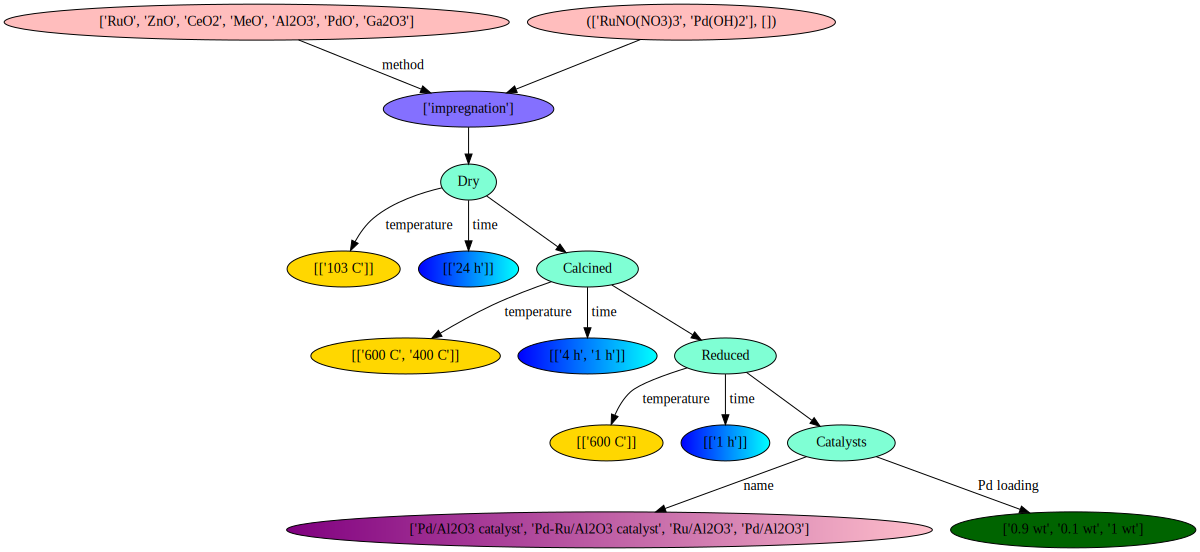

In [38]:
dot = gz.Digraph()
dot.node('Z', str(catalyst), style='filled', fillcolor='purple:pink')
dot.node('1', str(support), style='filled', fillcolor='#ff000042')
dot.node('2', str(precursor), style='filled', fillcolor='#ff000042')
dot.node('3', str(method), style='filled', fillcolor='lightslateblue')
dot.node('4', str(loading), style='filled', fillcolor='darkgreen')
dot.node('E', str(dry_tempurature), style='filled', fillcolor='gold1')
dot.node('G', str(dry_time), style='filled', fillcolor='blue:cyan')
dot.node('F', str(calcine_tempurature), style='filled', fillcolor='gold1')
dot.node('H', str(calcine_time), style='filled', fillcolor='blue:cyan')
dot.node('M', str(reduce_tempurature), style='filled', fillcolor='gold1')
dot.node('N', str(reduce_time), style='filled', fillcolor='blue:cyan')

dot.node('X', 'Dry', style='filled', fillcolor='aquamarine')
dot.node('Y', 'Calcined', style='filled', fillcolor='aquamarine')
dot.node('S', 'Reduced', style='filled', fillcolor='aquamarine')
dot.node('Q', 'Catalysts', style='filled', fillcolor='aquamarine')
dot.attr('node', shape='circle')
dot.edge('1', '3', label="method")
dot.edge('2', '3')
dot.edge('3', 'X')
dot.edge('X', 'E', label="temperature")
dot.edge('X', 'G', label="time")
dot.edge('X', 'Y')
dot.edge('Y', 'F', label="temperature")
dot.edge('Y', 'H', label="time")
dot.edge('Y', 'S')
dot.edge('S', 'M', label="temperature")
dot.edge('S', 'N', label="time")
dot.edge('S', 'Q')
dot.edge('Q', '4', label="Pd loading")
dot.edge('Q', 'Z', label="name")
dot

In [39]:
print(dot.source)

digraph {
	Z [label="['Pd/Al2O3 catalyst', 'Pd-Ru/Al2O3 catalyst', 'Ru/Al2O3', 'Pd/Al2O3']" fillcolor="purple:pink" style=filled]
	1 [label="['RuO', 'ZnO', 'CeO2', 'MeO', 'Al2O3', 'PdO', 'Ga2O3']" fillcolor="#ff000042" style=filled]
	2 [label="(['RuNO(NO3)3', 'Pd(OH)2'], [])" fillcolor="#ff000042" style=filled]
	3 [label="['impregnation']" fillcolor=lightslateblue style=filled]
	4 [label="['0.9 wt', '0.1 wt', '1 wt']" fillcolor=darkgreen style=filled]
	E [label="[['103 C']]" fillcolor=gold1 style=filled]
	G [label="[['24 h']]" fillcolor="blue:cyan" style=filled]
	F [label="[['600 C', '400 C']]" fillcolor=gold1 style=filled]
	H [label="[['4 h', '1 h']]" fillcolor="blue:cyan" style=filled]
	M [label="[['600 C']]" fillcolor=gold1 style=filled]
	N [label="[['1 h']]" fillcolor="blue:cyan" style=filled]
	X [label=Dry fillcolor=aquamarine style=filled]
	Y [label=Calcined fillcolor=aquamarine style=filled]
	S [label=Reduced fillcolor=aquamarine style=filled]
	Q [label=Catalysts fillcolor=aquam

In [40]:
gz.Source(dot.source,format='png')

dot.render('test-output/round-table.gv',view=True)

'test-output/round-table.gv.pdf'

Unable to init server: Could not connect: Connection refused
Cannot parse arguments: Cannot open display: 


In [41]:
pdf_path = "pdf_79/"  
pdfs = glob.glob("{}/*.pdf".format(pdf_path))  
L_pdfs = len(pdfs)

for num5 in range(0, L_pdfs):
    article_title = pdfs[num5]
    key_paragraph = paragraph_manul[num5]
    catalyst_reg, method_reg, support_reg, precursor_reg, loading_reg, dry_tempurature_reg, dry_time_reg, calcine_tempurature_reg, calcine_time_reg, reduce_tempurature_reg, reduce_time_reg = total_extract_mul(
        key_paragraph, key_paragraph) 

    
    dot = gz.Digraph()
    dot.node('Z', str(catalyst), style='filled', fillcolor='purple:pink')
    dot.node('1', str(support), style='filled', fillcolor='#ff000042')
    dot.node('2', str(precursor), style='filled', fillcolor='#ff000042')
    dot.node('3', str(method), style='filled', fillcolor='lightslateblue')
    dot.node('4', str(loading), style='filled', fillcolor='darkgreen')
    dot.node('E', str(dry_tempurature), style='filled', fillcolor='gold1')
    dot.node('G', str(dry_time), style='filled', fillcolor='blue:cyan')
    dot.node('F', str(calcine_tempurature), style='filled', fillcolor='gold1')
    dot.node('H', str(calcine_time), style='filled', fillcolor='blue:cyan')
    dot.node('M', str(reduce_tempurature), style='filled', fillcolor='gold1')
    dot.node('N', str(reduce_time), style='filled', fillcolor='blue:cyan')

    dot.node('X', 'Dry', style='filled', fillcolor='aquamarine')
    dot.node('Y', 'Calcined', style='filled', fillcolor='aquamarine')
    dot.node('S', 'Reduced', style='filled', fillcolor='aquamarine')
    dot.node('Q', 'Catalysts', style='filled', fillcolor='aquamarine')
    dot.attr('node', shape='circle')
    dot.edge('1', '3', label="method")
    dot.edge('2', '3')
    dot.edge('3', 'X')
    dot.edge('X', 'E', label="temperature")
    dot.edge('X', 'G', label="time")
    dot.edge('X', 'Y')
    dot.edge('Y', 'F', label="temperature")
    dot.edge('Y', 'H', label="time")
    dot.edge('Y', 'S')
    dot.edge('S', 'M', label="temperature")
    dot.edge('S', 'N', label="time")
    dot.edge('S', 'Q')
    dot.edge('Q', '4', label="Pd loading")
    dot.edge('Q', 'Z', label="name")
    dot
    print(dot.source) 
    

    print('======================================================')



article1:pdf_79/w-5.pdf
product:[]
method:['deposition']
support:['ZnO']
precursor:(['Pd(NO3)2'], [])
loading:['10 wt']
dry tempurature:[['room temp']]
dry time:[['overnight']]
calcine tempurature:[[]]
calcine time:[[]]
reduce tempurature:[[]]
reduce_time:[['2 h']]

digraph {
	Z [label="['Pd/Al2O3 catalyst', 'Pd-Ru/Al2O3 catalyst', 'Ru/Al2O3', 'Pd/Al2O3']" fillcolor="purple:pink" style=filled]
	1 [label="['RuO', 'ZnO', 'CeO2', 'MeO', 'Al2O3', 'PdO', 'Ga2O3']" fillcolor="#ff000042" style=filled]
	2 [label="(['RuNO(NO3)3', 'Pd(OH)2'], [])" fillcolor="#ff000042" style=filled]
	3 [label="['impregnation']" fillcolor=lightslateblue style=filled]
	4 [label="['0.9 wt', '0.1 wt', '1 wt']" fillcolor=darkgreen style=filled]
	E [label="[['103 C']]" fillcolor=gold1 style=filled]
	G [label="[['24 h']]" fillcolor="blue:cyan" style=filled]
	F [label="[['600 C', '400 C']]" fillcolor=gold1 style=filled]
	H [label="[['4 h', '1 h']]" fillcolor="blue:cyan" style=filled]
	M [label="[['600 C']]" fillcolor=go

In [42]:
pdf_path = "pdf_79/"  
pdfs = glob.glob("{}/*.pdf".format(pdf_path))  
L_pdfs = len(pdfs)
#L_pdfs = 1

for num5 in range(0, L_pdfs):
    #num5 = 3
    article_title = pdfs[num5]
    print(str(num5)+article_title)

0pdf_79/w-5.pdf
1pdf_79/5-5.pdf
2pdf_79/1-7.pdf
3pdf_79/w-6.pdf
4pdf_79/3-7.pdf
5pdf_79/w-13.pdf
6pdf_79/w-27.pdf
7pdf_79/8-4.pdf
8pdf_79/11-1.pdf
9pdf_79/9-2.pdf
10pdf_79/5-4.pdf
11pdf_79/6-2.pdf
12pdf_79/9-3.pdf
13pdf_79/w-14.pdf
14pdf_79/w-9.pdf
15pdf_79/1-4.pdf
16pdf_79/w-20.pdf
17pdf_79/7-1.pdf
18pdf_79/2-6.pdf
19pdf_79/w-3.pdf
20pdf_79/4-7.pdf
21pdf_79/w-11.pdf
22pdf_79/6-6.pdf
23pdf_79/w-23.pdf
24pdf_79/5-7.pdf
25pdf_79/6-3.pdf
26pdf_79/w-15.pdf
27pdf_79/5-6.pdf
28pdf_79/2-3.pdf
29pdf_79/w-28.pdf
30pdf_79/w-8.pdf
31pdf_79/4-4.pdf
32pdf_79/1-8.pdf
33pdf_79/w-22.pdf
34pdf_79/w-18.pdf
35pdf_79/5-1.pdf
36pdf_79/3-8.pdf
37pdf_79/7-2.pdf
38pdf_79/12-4.pdf
39pdf_79/7-8.pdf
40pdf_79/4-3.pdf
41pdf_79/w-24.pdf
42pdf_79/w-2.pdf
43pdf_79/8-5.pdf
44pdf_79/w-25.pdf
45pdf_79/1-5.pdf
46pdf_79/2-10.pdf
47pdf_79/3-9.pdf
48pdf_79/w-12.pdf
49pdf_79/9-7.pdf
50pdf_79/3-2.pdf
51pdf_79/1-1.pdf
52pdf_79/w-16.pdf
53pdf_79/2-1.pdf
54pdf_79/w-21.pdf
55pdf_79/w-19.pdf
56pdf_79/w-17.pdf
57pdf_79/1-3.pdf
58pd